In [58]:
import gym
import sys
import numpy as np
import matplotlib
from collections import defaultdict, namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

%matplotlib inline
matplotlib.style.use("ggplot")

In [59]:
env = gym.envs.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [60]:
state_samples = np.array([env.observation_space.sample() for x in range(10000)])
# Num	Observation 	Min 	Max
# 0 	position	-1.2	0.6
# 1 	velocity	-0.07	0.07
position_max = np.amax(observation_examples[:, 0])
position_min = np.amin(observation_examples[:, 0])
velocity_max = np.amax(observation_examples[:, 1])
velocity_min = np.amin(observation_examples[:, 1])

scaler = StandardScaler()
scaler.fit(state_samples)
scaler_samples = scaler.transform(state_samples)

featurizer_state = RBFSampler(gamma=0.5, n_components=100)
featurizer_state.fit(scaler_samples)
print(featurizer_state)

state = env.reset()
print(observation_examples[20])
featurized = featurizer_state.transform([observation_examples[10]])

RBFSampler(gamma=0.5, n_components=100, random_state=None)
[0.46063438 0.04032445]


In [75]:
class ValueFunction(object):
    """
    Value Funciton approximator.
    """
    def __init__(self):
        # sampleing envrionment state in order to featurize it. 
        state_samples = np.array([env.observation_space.sample() for x in range(10000)])

        # Standardize features by removing the mean and scaling to unit variance
        self.scaler = StandardScaler()
        self.scaler.fit(state_samples)
        scaler_samples = scaler.transform(state_samples)

        # Approximates feature map of an RBF kernel 
        # by Monte Carlo approximation of its Fourier transform. 
        self.featurizer_state = RBFSampler(gamma=0.5, n_components=100)
        self.featurizer_state.fit(scaler_samples)

        # action model for SGD regressor
        self.action_models = []
        nA = env.action_space.n
        for na in range(nA):
            # Linear classifiers with SGD training.
            model = SGDRegressor(learning_rate="constant")
            model.partial_fit([self.__featurize_state(env.reset())], [0])
            self.action_models.append(model)
        
        # print(self.action_models)
            
    def __featurize_state(self, state):
        scaler_state = self.scaler.transform([state])
        return self.featurizer_state.transform(scaler_state)[0]
    
    def predict(self, state):
        curr_features = self.__featurize_state(state)
        action_probs = np.array([m.predict([curr_features])[0] for m in self.action_models])
        # print(action_probs)
        return action_probs

    def update(self, state, action, y):
        curr_features = self.__featurize_state(state)
        self.action_models[action].partial_fit([curr_features], [y])
        
class QLearning():
    def __init__(self, env, num_episodes, discount=1.0, alpha=0.5, epsilon=0.1, ep_decay=1.0):
        self.nA = env.action_space.n
        self.nS = env.observation_space.shape[0]
        self.env = env
        self.num_episodes = num_episodes
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.vfa = ValueFunction()
        self.ep_decay = ep_decay
        
        # Keeps track of useful statistics
        record = namedtuple("Record", ["episode_lengths","episode_rewards"])
        self.rec = record(episode_lengths=np.zeros(num_episodes),
                          episode_rewards=np.zeros(num_episodes))
        
    def __epislon_greedy_policy(self, epsilon, nA):

        def policy(state):
            A = np.ones(nA, dtype=float) * epsilon / nA
            Q = self.vfa.predict(state)
            best_action = np.argmax(Q)
            A[best_action] += (1.0 - epsilon)
            return A

        return policy

    def __next_action(self, prob):
        return np.random.choice(np.arange(len(prob)), p=prob)

    def qlearning(self):
        """
        Q-learning algo
        """
        sumlist = []

        for i_episode in range(self.num_episodes):
            # Print out which episode we are on
            if 0 == (i_episode) % 10:
                print("Episode {} in {}".format(i_episode+1, self.num_episodes))
                # sys.stdout.flush()
            
            # following current policy
            policy_epsilon = self.epsilon*self.ep_decay**i_episode
            policy = self.__epislon_greedy_policy(policy_epsilon, self.nA)
            
            step = 0
            # Initialize S
            state = self.env.reset()
            
            # Repeat (for each step of episode)
            while(True):
                # Choose A from S using policy derived from Q
                prob_actions = policy(state)
                action = self.__next_action(prob_actions)
                
                # Take action A, observe R, S'
                next_state, reward, done, info = env.step(action)
                
                # update history record
                self.rec.episode_lengths[i_episode] += reward
                self.rec.episode_rewards[i_episode] = step
                
                # TD update: Q(S; A)<-Q(S; A) + aplha*[R + discount * max Q(S'; a) − Q(S; A)]
                q_next_value = self.vfa.predict(next_state)
                td_target = reward + self.discount * np.max(q_next_value)
                self.vfa.update(state, action, td_target)
                
                if done:
                    # until S is terminal
                    print("Episode finished after {} timesteps".format(step))
                    sumlist.append(step)
                    break
                else:
                    step += 1
                    # S<-S'
                    state = next_state
                    
        iter_time = sum(sumlist)/len(sumlist)
        print("MountainCar game iter average time is: {}".format(iter_time))

cls_qlearning = QLearning(env, num_episodes=200)
cls_qlearning.qlearning()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Episode 1 in 200
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode 11 in 200
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode 21 in 200
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after

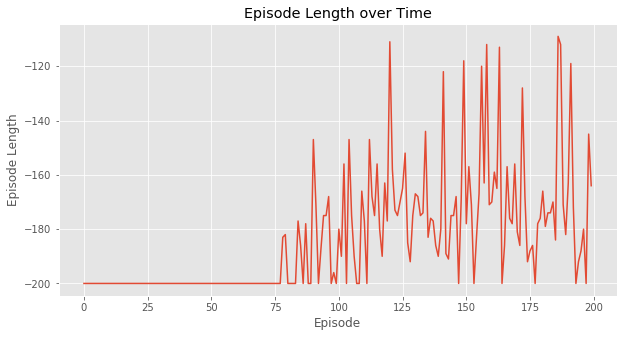

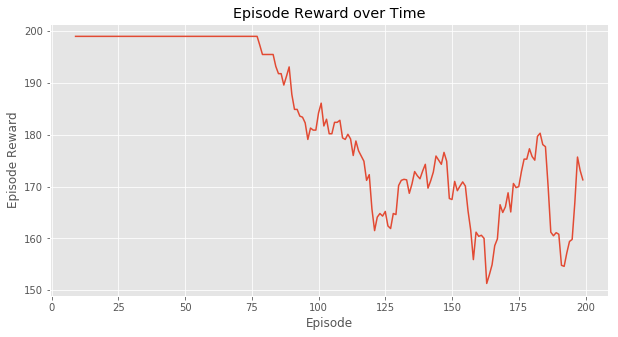

(<matplotlib.figure.Figure at 0x158fe8d0>,
 <matplotlib.figure.Figure at 0x184edb38>)

In [77]:
from matplotlib import pyplot as plt
import pandas as pd

def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths[:200])
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards[:200]).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.title("Episode Reward over Time".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    return fig1, fig2

plot_episode_stats(cls_qlearning.rec)